In [2]:
def drawlines(img1, img2, lines, pts1, pts2):

    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

In [3]:
def lineEq2PointGivenX(eq, x):
    return int(eq[0]*x+eq[2])/((-1)*eq[1])

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread('cones/im2.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('cones/im6.png', cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

matches = bf.match(desL,desR)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(imgL,kpL,imgR,kpR, matches[:20], imgL, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(img3)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()


<Figure size 2000x2000 with 1 Axes>

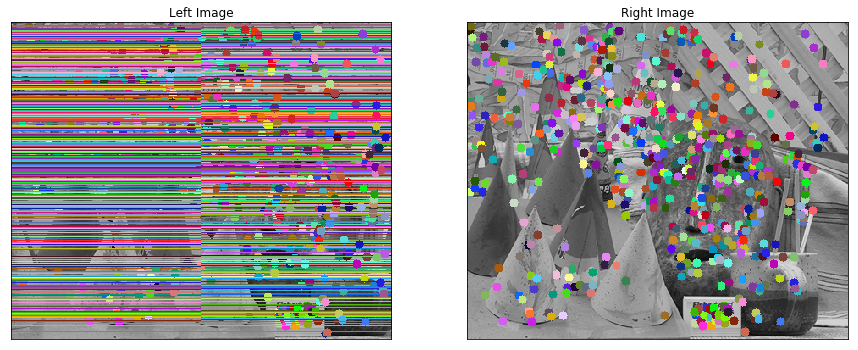

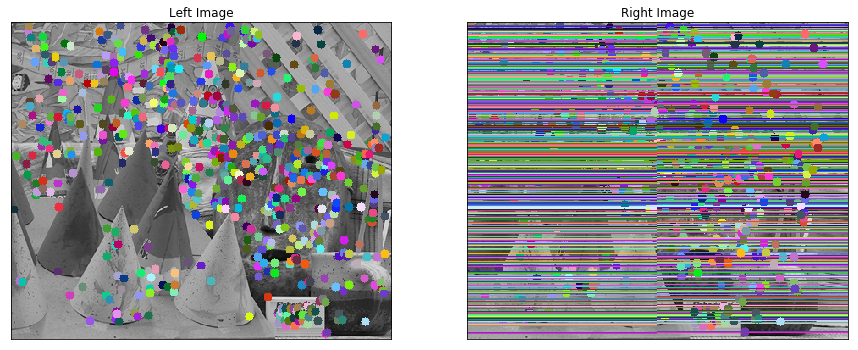

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread('cones/im2.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('cones/im6.png', cv2.IMREAD_GRAYSCALE)

sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# match descriptors (find the best two matches for each descriptor)
matches = bf.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

(Text(0.5,1,'Patch Line'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

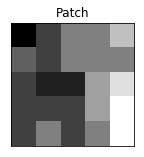

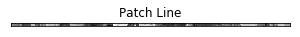

In [6]:
# draw the incorrect line (found through trial and error)

imgR3, imgL3 = drawlines(imgR, imgL, linesR[166:167], ptsR[166:167], ptsL[166:167])

yCoordBeg = int(lineEq2PointGivenX(linesL[166], 0))
yCoordEnd = int(lineEq2PointGivenX(linesL[166], imgR.shape[1]))
patch = imgR[ptsR[166][0]-2:ptsR[166][0]+3, ptsR[166][1]-2:ptsR[166][1]+3]
patchLine = imgR[yCoordEnd-2:yCoordBeg+2, :]

plt.figure(figsize=(5,5))
plt.subplot(211), plt.imshow(patch, cmap="gray")
plt.title("Patch"), plt.xticks([]), plt.yticks([])

plt.figure(figsize=(5,5))
plt.subplot(211), plt.imshow(patchLine, cmap="gray")
plt.title("Patch Line"), plt.xticks([]), plt.yticks([])

(<matplotlib.axes._subplots.AxesSubplot at 0x11c378898>,
 [<matplotlib.lines.Line2D at 0x11b4cfa20>])

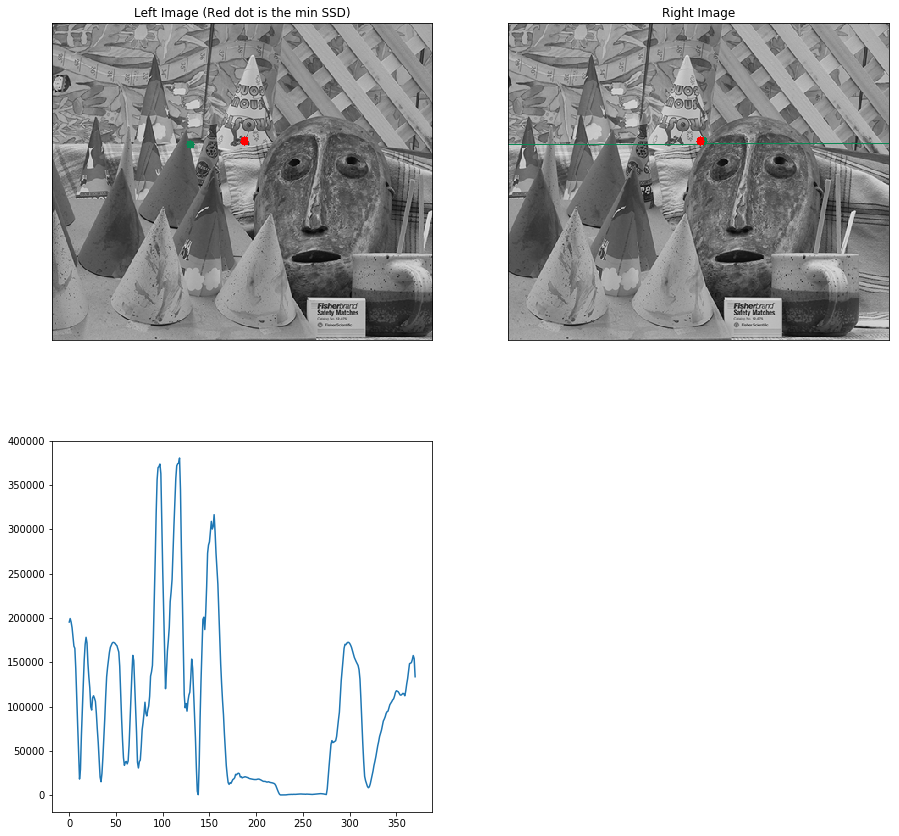

In [9]:
resL = cv2.matchTemplate(imgR, patch, cv2.TM_SQDIFF)

resL = resL.T[yCoordBeg]
min_loc = np.argmin(resL)

imgL3 = cv2.circle(imgL3, (min_loc, yCoordBeg), 5, 255, -1)
imgR3 = cv2.circle(imgR3, (min_loc, yCoordBeg), 5, 255, -1)

plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(imgL3, cmap="gray")
plt.title("Left Image (Red dot is the min SSD)"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(imgR3, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])

res = resL.flatten()

plt.subplot(223), plt.plot(res)
# plt.show()


There were multiple points with very small SSD values close to each other. This is because there are multiple pathces along the epipolar line that match the pixel. 

In order to increase the accuracy we could increase the patch size  or lower the ratio of patch size to the image size. This way we would be looking into more pixels and comparing the results.

If we had found one match with the lowest SSD and it was wrong, it could be because of the brute force matcher and SIFT decriptors. This means the descriptor is being placed with the wrong cluster 